# LSTM decoding exploration

Going to be looking at using LSTMs (with potentially some changes to the cost function) to decode EMGs from cortical data. This is all based off work from Steph and Josh.


Going to start with the old Jango data, then update from there as necessary.

In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
# import ipympl

# we'll use ridge regression as a comparisson
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tkinter import Tk
from tkinter import filedialog as fd # just so I don't have to repeatedly manually enter filenames

# and tf stuff
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K # this was in Josh's version. Not sure why can't use numpy

/home/klb807/miniconda3/envs/generalDevelopment/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-08-17 14:26:27.733214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 14:26:27.733233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# %matplotlib inline
import ipympl

### Import data

In [3]:
# request the filename
root = Tk()
mat_fn = fd.askopenfilename(master=root,filetypes=[('matlab data','*.mat')])
root.destroy()

Different loading code if it's data from Josh vs XDS stuff

**Josh**
It looks like this will input a dictionary containing (among other things) numpy arrays for each of the datasets for the day. We'll pull in each of them, and parse accordingly.

In the "binned" numpy arrays (two levels down), the organization seems to be:

0. timestamps
1. metadata
2. EMG names
3. EMG data
4. Force names
5. Force data
6. electrode and unit number
7. channel and unit number
8. Firing Rates (in hz)
9. Kin (cursor kin?) names
10. Kin (cursor kin?) data
11. Vel Data
12. Vel Names
13. Accel Data
14. Accel Names
15. Digital Words and timestamps
16. Targets:

    0. corner locations and appearance time 
    1. rotations and appearance time

17. Trial table data
18. Trial Table Labels
19. 
20. 
21. 

In [4]:
# load it in
data = loadmat(mat_fn)


In [5]:
def load_josh_mat(curr_data):
    timestamps = curr_data[0][0][0].reshape(-1)
    # create a couple of pandas data frames -- this will make things a bit easier

    # EMG
    emg_names = [curr_data[0][0][2][ii][0][0] for ii in np.arange(len(curr_data[0][0][2]))]
    EMG = pd.DataFrame(curr_data[0][0][3], columns=emg_names, index=timestamps)

    # Forces
    force_names = [curr_data[0][0][4][ii][0][0] for ii in np.arange(len(curr_data[0][0][4]))]
    force = pd.DataFrame(curr_data[0][0][5], columns=force_names, index=timestamps)

    # Firing Rates
    channel_names = [f"cc{row[0]:03d}ee{row[1]}" for row in curr_data[0][0][7]]
    firing = pd.DataFrame(curr_data[0][0][8], columns=channel_names, index=timestamps)

    # Kin -- not sure if cursor or ang of wrist. Will need to check
    kin_names = curr_data[0][0][9]
    vel_names = curr_data[0][0][12]
    acc_names = curr_data[0][0][14]
    kin = pd.DataFrame(curr_data[0][0][10], columns=kin_names, index=timestamps)
    try:
        kin = kin.join(pd.DataFrame(curr_data[0][0][11], columns=vel_names, index=timestamps))
        kin = kin.join(pd.DataFrame(curr_data[0][0][13], columns=acc_names, index=timestamps))
    except:
        pass

    # trial table
    trial_names = curr_data[0][0][18]
    trial_table = pd.DataFrame(curr_data[0][0][17], columns=trial_names)

    return timestamps, firing, EMG, force, kin


XDS:

## Model building 
Look through a couple of different model types, look to see how they are trained


### Linear with Static Non-linearity

Using the lab default -- build a wiener filter, fit it, then fit with a static polynomial on top of the form

$Ax^2 + Bx + C$

Where $x$ is the original EMG prediction, and the output is the new EMG prediction

Alternatively, I have also allowed to predict using an exponential activation 

$Ae^{Bx} + C$

Also giving the options for a sigmoid or an exponential


**Starting with defining our nonlinearity methods**

In [10]:
# using scipy's least_squares:
def non_linearity(p, y_pred, nonlinear_type):
    if nonlinear_type == 'poly':
        return p[0] + p[1]*y_pred + p[2]*y_pred**2
    elif nonlinear_type == 'exponential':
        return p[0]*np.exp(p[1]*y_pred) + p[2]
    elif nonlinear_type == 'sigmoid':
        return p[1] * 1/(1 + np.exp(-10*(y_pred-p[0])))

def non_linearity_residuals(p, y_pred, y_act, nonlinear_type):
    if nonlinear_type == 'poly':
        return y_act - (p[0] + p[1]*y_pred + p[2]*y_pred**2)
    elif nonlinear_type == 'exponential':
        return y_act - (p[0]*np.exp(p[1]*y_pred) + p[2])
    elif nonlinear_type == 'sigmoid':
        return y_act - (p[1] * 1/(1 + np.exp(-10*(y_pred-p[0]))))



Next a function that compares Wiener filter models with Wiener cascades, reports the VAF (Cooefficient of Determination) and gives plots for the validation predictions

In [11]:
# Set up a function that we can just call multiple times, so then we can just quickly run through all of the different combinations


def basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type):
    wiener_input = pd.DataFrame() # empty dataframe
    n_lags = 10 # number of lags
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(train_firing.columns, train_firing.columns+f"_lag{ii}"))
        wiener_input = wiener_input.join(train_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')

    wiener_test = pd.DataFrame() # empty dataframe
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(test_firing.columns, test_firing.columns+f"_lag{ii}"))
        wiener_test = wiener_test.join(test_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')
        
    wiener_retrain = pd.DataFrame() # empty dataframe
    for ii in np.arange(n_lags): # create the lagged dataframe
        col_dict = dict(zip(retrain_firing.columns, retrain_firing.columns+f"_lag{ii}"))
        wiener_retrain = wiener_retrain.join(retrain_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')



    if nonlinear_type == 'poly':
        init_pred = [.1, .1, .1]
    elif nonlinear_type == 'exponential':
        init_pred = [1, .1, .2]
    elif nonlinear_type == 'sigmoid':
        init_pred = [.1, .5]

    mdl_A = linear_model.LinearRegression(fit_intercept=True)
    mdl_B = {} # a dictionary of numpy polynomials. Probably a better way to do this, maybe Xuan's method... oh well

    mdl_A.fit(wiener_input, train_EMG)# fit the first model
    prefit_EMG = mdl_A.predict(wiener_input) # get the initially predicted EMGs
    retrain_pred = mdl_A.predict(wiener_retrain) # from a training set on a separate condition -- to properly hold out test data
    prefit_VAF = metrics.explained_variance_score(train_EMG, prefit_EMG, multioutput='raw_values')
    nonlin_EMG = np.zeros(prefit_EMG.shape)

    print('Training Results\n')

    for ii in np.arange(len(train_EMG.columns)):
        muscle = train_EMG.columns[ii]
        mdl_B[muscle] = least_squares(non_linearity_residuals, init_pred, args=(prefit_EMG[:,ii], train_EMG.iloc[:,ii].to_numpy(), nonlinear_type)).x
        # print('--------------------------------------------------------')
        print(muscle)
        print(f"\tLinear VAF: {prefit_VAF[ii]:.03f}")
        nonlin_EMG[:,ii] = non_linearity(mdl_B[muscle],(prefit_EMG[:,ii]), nonlinear_type)
        print(f"\tNonLinear VAF: {metrics.explained_variance_score(train_EMG.iloc[:,ii],nonlin_EMG[:,ii]):.03f}")




    # predicting the test set
    prefit_test = mdl_A.predict(wiener_test)
    prefit_test_VAF = metrics.explained_variance_score(test_EMG, prefit_test, multioutput='raw_values')
    nonlin_test = np.zeros(prefit_test.shape)
    nonlin_within_test = np.zeros(prefit_test.shape)
    nonlin_VAF = np.zeros(prefit_test_VAF.shape)
    nonlin_within_VAF = np.zeros(prefit_test_VAF.shape)
    mdl_C = {} # for a separate non-linearity, built for the second condition.

    print('\n------------------------------------------------------------\n')
    print('Testing Results\n')
    for ii in np.arange(len(train_EMG.columns)):
        muscle = test_EMG.columns[ii]
        mdl_C[muscle] = least_squares(non_linearity_residuals, init_pred, args=(retrain_pred[:,ii], retrain_EMG.iloc[:,ii].to_numpy(), nonlinear_type)).x
        # print('--------------------------------------------------------')
        print(muscle)
        print(f"\tLinear VAF: {prefit_test_VAF[ii]:.03f}")
        nonlin_test[:,ii] = non_linearity(mdl_B[muscle],(prefit_test[:,ii]), nonlinear_type)
        nonlin_within_test[:,ii] = non_linearity(mdl_C[muscle],(prefit_test[:,ii]), nonlinear_type)
        nonlin_VAF[ii] = metrics.explained_variance_score(test_EMG.iloc[:,ii],nonlin_test[:,ii])
        nonlin_within_VAF[ii] = metrics.explained_variance_score(test_EMG.iloc[:,ii],nonlin_within_test[:,ii])
        print(f"\tPre-built Nonlinearity VAF: {nonlin_VAF[ii]:.03f}")
        print(f"\tRe-built Nonlinearity VAF: {nonlin_within_VAF[ii]:.03f}")

    # Plotting the test data -- so that we can see how  the non-linearities act between types
    n_rows = int(np.ceil(np.sqrt(len(train_EMG.columns))))
    fig_nl_test, ax_nl_test = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

    for muscle_ii in np.arange(len(train_EMG.columns)):
        row_i = int(muscle_ii//n_rows)
        col_i = int(muscle_ii%n_rows)
        ax_nl_test[row_i,col_i].plot(test_timestamps, test_EMG.iloc[:,muscle_ii], label='Recorded')
        ax_nl_test[row_i,col_i].plot(test_timestamps,prefit_test[:,muscle_ii], label=f'Linear VAF: {prefit_test_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].plot(test_timestamps,nonlin_test[:,muscle_ii], label=f'NonLin VAF: {nonlin_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].plot(test_timestamps,nonlin_within_test[:,muscle_ii], label=f'Rebuilt NonLin VAF: {nonlin_within_VAF[muscle_ii]:.03f}')
        ax_nl_test[row_i,col_i].set_title(f"{test_EMG.columns[muscle_ii]}")
        _ = ax_nl_test[row_i,col_i].legend()

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_nl_test[row_i,col_i].spines[spine].set_visible(False)

    # let's also plot the VAFs in a clean manner so that it's easy to compare
    fig_vaf, ax_vaf = plt.subplots()
    i_muscles = np.arange(len(test_EMG.columns)) # indexing on the x axis
    bar_width = .25

    ax_vaf.bar(i_muscles, prefit_test_VAF, width = bar_width, label='Linear')
    ax_vaf.bar(i_muscles + bar_width, nonlin_VAF, width = bar_width, label='Nonlinear')
    ax_vaf.bar(i_muscles + 2*bar_width, nonlin_within_VAF, width = bar_width, label='Rebuilt Nonlinear')

    ax_vaf.set_xticks(i_muscles + 1*bar_width)
    ax_vaf.set_xticklabels(test_EMG.columns)

    ax_vaf.set_ylim([-.05, 1.05])
    ax_vaf.set_xlabel('Muscle')
    ax_vaf.set_ylabel('Coefficient of Determination')

    ax_vaf.legend()

    # For each bar in the chart, add a text label.
    for bar in ax_vaf.patches:
        # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:.02f}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        ax_vaf.spines[spine].set_visible(False)


In [12]:
def LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps, plot=True):
    # hyper params
    layer_0_units = 200
    drop_in = .25     # input dropout percentage for LSTM layer
    drop_rec = .25    # recurrent dropout for LSTM
    drop_lay = .25    # dropout layer?

    # # input hyper params -- reshape input vector
    # batch_size = 64 # why not? will test to see training accuracy after
    # seq_len = train_firing.shape[0]//batch_size # splitting out the batches
    n_neurons = train_firing.shape[1] # number of neurons
    n_EMGs = train_EMG.shape[1]
    seq_len = 10
    rnn_train_i = np.zeros((train_firing.shape[0],seq_len, train_firing.shape[1]))
    rnn_test_i = np.zeros((test_firing.shape[0],seq_len, test_firing.shape[1]))
    rnn_train_o = train_EMG.to_numpy()
    rnn_test_o = test_EMG.to_numpy()
    
    # normalize the EMGs
    EMG_std = np.std(rnn_train_o, axis=0)
    for ii in np.arange(rnn_train_o.shape[1]):
        rnn_train_o[:,ii] = rnn_train_o[:,ii]/EMG_std[ii]
        rnn_test_o[:,ii] = rnn_test_o[:,ii]/EMG_std[ii]
    
    # create the sequences
    for ii in np.arange(10):
        rnn_train_i[:,ii,:] = train_firing.shift(-ii, fill_value=0).to_numpy()
        rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()

    # Set up the LSTMs
    mdl = tf.keras.models.Sequential()


    mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
    if drop_lay:
        mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
#     mdl.add(tf.keras.layers.Dense(train_EMG.shape[1], activation='relu')) # dense combination layer
    mdl.add(tf.keras.layers.Dense(train_EMG.shape[1])) # dense combination layer
    mdl.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    mdl.fit(rnn_train_i, rnn_train_o, epochs=20, verbose=False)
    
    
    train_pred = mdl.predict(rnn_train_i)
    test_pred = mdl.predict(rnn_test_i)
    train_VAFs = metrics.explained_variance_score(rnn_train_o, train_pred, multioutput='raw_values')
    test_VAFs = metrics.explained_variance_score(rnn_test_o, test_pred, multioutput='raw_values')
    
    print('----------------------------------------')
    for ii in np.arange(len(train_EMG.columns)):
        print(train_EMG.columns[ii])
        print(f"\tTrain VAF: {train_VAFs[ii]}")
        print(f"\tTest VAF: {test_VAFs[ii]}")
    
    
    # plottin
    n_rows = int(np.ceil(np.sqrt(len(train_EMG.columns))))
    fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

    for muscle_ii in np.arange(len(train_EMG.columns)):
        row_i = int(muscle_ii//n_rows)
        col_i = int(muscle_ii%n_rows)
        ax_lstm[row_i,col_i].plot(test_timestamps, test_EMG.iloc[:,muscle_ii]*EMG_std[ii], label='Recorded')
        ax_lstm[row_i,col_i].plot(test_timestamps,test_pred[:,muscle_ii]*EMG_std[ii], label=f'LSTM VAF: {test_VAFs[muscle_ii]:.03f}')
        ax_lstm[row_i,col_i].set_title(f"{test_EMG.columns[muscle_ii]}")
        _ = ax_lstm[row_i,col_i].legend()

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_lstm[row_i,col_i].spines[spine].set_visible(False)
    
    
    # let's also plot the VAFs in a clean manner so that it's easy to compare
    fig_vaf, ax_vaf = plt.subplots()
    i_muscles = np.arange(len(test_EMG.columns)) # indexing on the x axis
    bar_width = .3

    ax_vaf.bar(i_muscles, train_VAFs, width = bar_width, label='Train')
    ax_vaf.bar(i_muscles + bar_width, test_VAFs, width = bar_width, label='Test')

    ax_vaf.set_xticks(i_muscles + bar_width/2)
    ax_vaf.set_xticklabels(test_EMG.columns)

    ax_vaf.set_ylim([-.05, 1.05])
    ax_vaf.set_xlabel('Muscle')
    ax_vaf.set_ylabel('VAF')

    ax_vaf.legend()

    # For each bar in the chart, add a text label.
    for bar in ax_vaf.patches:
        # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:.02f}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        ax_vaf.spines[spine].set_visible(False)
    
    return 


In [6]:
# weight the losses by the std of that particular range in time and muscle.
# for hybrid decoders
def hybrid_weight_loss(target, pred):
    # inputs: 
    #         target is the recorded data, plus the weights since this needs to be callable by tf
    #                First half of the columns of the data will be EMG, second half will be the weights
    #         pred   is the current prediction values
    num_targets = K.shape(target)[1]//2 # number of cols / 2
    err = (target[:, 0:num_targets] - pred[:,0:num_targets]) # subtract the values
    se = K.square(err) * target[:,num_targets:] # multiply the square error by the gains
    mse = K.mean(se, axis=-1)
    return mse
    


In [ ]:
# vREx loss function
def vrex_loss(target, pred):
    # from the Risk Extrapolation paper
    B = 3 #
    

In [7]:
def LSTM_across_weighted(train_firing, train_EMG, test_firing, test_EMG, test_timestamps, plot=True):
    if type(train_firing) is not list:
        print(f"training data must be a list, not a {type(train_firing)}")
        return -1
    
    # hyper params
    layer_0_units = 200
    drop_in = .25     # input dropout percentage for LSTM layer
    drop_rec = .25    # recurrent dropout for LSTM
    drop_lay = .25    # dropout layer?
    
    # size and name of outputs
    n_target = train_EMG[0].shape[1] # dimensionality of target (EMGs usually)
    col_names = train_EMG[0].columns
    
    
    # put together the training targets 
    # This means both the EMGs and the variance for that portion of the training set
    loss_weights = np.ndarray((0,n_target)) # weights for the training losses
    rnn_train_o = np.ndarray((0,n_target*2)) # rnn target for training set. Going to also contain the weights
    rnn_test_o = test_EMG.to_numpy() # don't need the weights for the test set
    
    # initialize the input sequence data
    n_neurons = train_firing[0].shape[1] # number of neurons
    seq_len = 10
    rnn_train_i = np.ndarray((0,seq_len, n_neurons))
    rnn_test_i = np.ndarray((test_firing.shape[0], seq_len, n_neurons))
    
    # training target set
    for target in train_EMG:
        # put together the weights -- the variances, since we're doing MSE as our training loss
        temp_var = np.matmul(np.ones((target.shape[0],1)),np.var(target.to_numpy(), axis=0).reshape(1,-1))
#         loss_weights = np.append(loss_weights,temp_var, axis=0)
        # append the training targets
        temp_train = np.append(target.to_numpy(), 1./temp_var, axis=1)
        rnn_train_o = np.append(rnn_train_o, temp_train, axis=0)
    
    
    # testing target set -- have to append the neural firing
    for train in train_firing:
        temp_train_i = np.ndarray((train.shape[0], seq_len, n_neurons))
        for ii in np.arange(seq_len):
            temp_train_i[:,ii,:] = train.shift(-ii, fill_value=0).to_numpy()
        rnn_train_i = np.append(rnn_train_i, temp_train_i, axis=0)
            
    for ii in np.arange(seq_len):
        rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).to_numpy()
        
    
        # Set up the LSTMs
    mdl = tf.keras.models.Sequential()


    mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
    if drop_lay:
        mdl.add(tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
#     mdl.add(tf.keras.layers.Dense(n_target*2, activation='relu')) # dense combination layer -- x2 to account for weights
    mdl.add(tf.keras.layers.Dense(n_target*2)) # try with linear -- how does it compare?
    mdl.compile(loss=hybrid_weight_loss, optimizer='rmsprop', metrics=['MeanAbsoluteError'])
    
#     mdl.fit(rnn_train_i, rnn_train_o, epochs=20, batch_size=256, verbose=True)
    mdl.fit(rnn_train_i, rnn_train_o, epochs=20, verbose=2)
    
    
    train_pred = mdl.predict(rnn_train_i)[:,:n_target]
    test_pred = mdl.predict(rnn_test_i)[:,:n_target]
    train_VAFs = metrics.explained_variance_score(rnn_train_o[:,:n_target], train_pred, multioutput='raw_values')
    test_VAFs = metrics.explained_variance_score(rnn_test_o, test_pred, multioutput='raw_values')
    
    print('----------------------------------------')
    for ii in np.arange(n_target):
        print(col_names[ii])
        print(f"\tTrain VAF: {train_VAFs[ii]}")
        print(f"\tTest VAF: {test_VAFs[ii]}")
    
    
    # plottin
    n_rows = int(np.ceil(np.sqrt(n_target)))
    fig_lstm, ax_lstm = plt.subplots(nrows=n_rows, ncols=n_rows, sharex=True, constrained_layout=True)

    for muscle_ii in np.arange(n_target):
        row_i = int(muscle_ii//n_rows)
        col_i = int(muscle_ii%n_rows)
        ax_lstm[row_i,col_i].plot(test_timestamps, rnn_test_o[:,muscle_ii], label='Recorded')
        ax_lstm[row_i,col_i].plot(test_timestamps,test_pred[:,muscle_ii], label=f'LSTM VAF: {test_VAFs[muscle_ii]:.03f}')
        ax_lstm[row_i,col_i].set_title(f"{col_names[muscle_ii]}")
        _ = ax_lstm[row_i,col_i].legend()

        # turn off the spines
        for spine in ['right','top','bottom','left']:
            ax_lstm[row_i,col_i].spines[spine].set_visible(False)
    
    
    # let's also plot the VAFs in a clean manner so that it's easy to compare
    fig_vaf, ax_vaf = plt.subplots()
    i_muscles = np.arange(n_target) # indexing on the x axis
    bar_width = .3

    ax_vaf.bar(i_muscles, train_VAFs, width = bar_width, label='Train')
    ax_vaf.bar(i_muscles + bar_width, test_VAFs, width = bar_width, label='Test')

    ax_vaf.set_xticks(i_muscles + bar_width/2)
    ax_vaf.set_xticklabels(col_names)

    ax_vaf.set_ylim([-.05, 1.05])
    ax_vaf.set_xlabel('Muscle')
    ax_vaf.set_ylabel('VAF')

    ax_vaf.legend()

    # For each bar in the chart, add a text label.
    for bar in ax_vaf.patches:
        # The text annotation for each bar should be its height.
        bar_value = bar.get_height()
        # Format the text with commas to separate thousands. You can do
        # any type of formatting here though.
        text = f'{bar_value:.02f}'
        # This will give the middle of each bar on the x-axis.
        text_x = bar.get_x() + bar.get_width() / 2
        # get_y() is where the bar starts so we add the height to it.
        text_y = np.max([bar.get_y() + bar_value, 0.01]) # keep it from going too far below zero, and disappearing
        # If we want the text to be the same color as the bar, we can
        # get the color like so:
        bar_color = bar.get_facecolor()
        # If you want a consistent color, you can just set it as a constant, e.g. #222222
        ax_vaf.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
                size=12)

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        ax_vaf.spines[spine].set_visible(False)

    

### Compare different combinations of train/test sets

So that we can quickly run through all of the iterations

Set the nonlinearity type, to compare across iterations

In [13]:
nonlinear_type = 'poly'



First train wrist movement, test wrist movement

Training Results

FCU
	Linear VAF: 0.370
	NonLinear VAF: 0.431
ECU
	Linear VAF: 0.623
	NonLinear VAF: 0.665
ECR
	Linear VAF: 0.736
	NonLinear VAF: 0.738

------------------------------------------------------------

Testing Results

FCU
	Linear VAF: 0.148
	Pre-built Nonlinearity VAF: 0.251
	Re-built Nonlinearity VAF: 0.251
ECU
	Linear VAF: 0.572
	Pre-built Nonlinearity VAF: 0.654
	Re-built Nonlinearity VAF: 0.654
ECR
	Linear VAF: 0.708
	Pre-built Nonlinearity VAF: 0.711
	Re-built Nonlinearity VAF: 0.711
188/188 [==============================] - 1s 2ms/step
----------------------------------------
FCU
	Train VAF: 0.47565662435115796
	Test VAF: 0.25966224142314187
ECU
	Train VAF: 0.7338313619558359
	Test VAF: 0.6698640844083988
ECR
	Train VAF: 0.800600172761539
	Test VAF: 0.7485568968514816


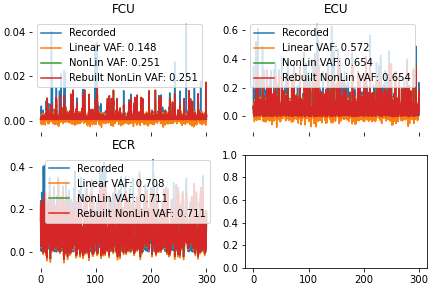

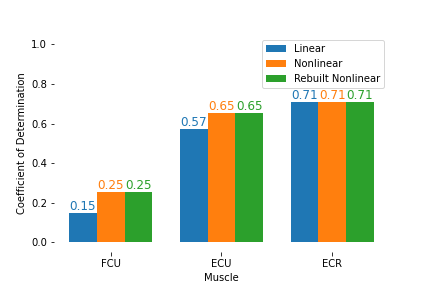

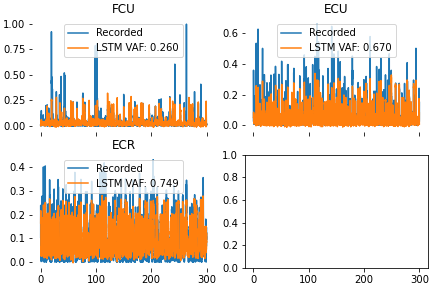

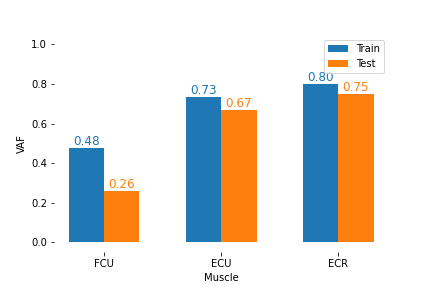

In [14]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
# using the training set twice as the "refit" gain -- for sanity's sake
basic_decoder_comparison(train_firing, train_EMG, train_firing, train_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

Train wrist movement, test iso

Training Results

FCU
	Linear VAF: 0.370
	NonLinear VAF: 0.431
ECU
	Linear VAF: 0.623
	NonLinear VAF: 0.665
ECR
	Linear VAF: 0.736
	NonLinear VAF: 0.738

------------------------------------------------------------

Testing Results

FCU
	Linear VAF: -1297.084
	Pre-built Nonlinearity VAF: -1164.354
	Re-built Nonlinearity VAF: 0.047
ECU
	Linear VAF: -116.181
	Pre-built Nonlinearity VAF: -79.311
	Re-built Nonlinearity VAF: 0.358
ECR
	Linear VAF: -12.680
	Pre-built Nonlinearity VAF: -11.636
	Re-built Nonlinearity VAF: 0.461
188/188 [==============================] - 1s 2ms/step
----------------------------------------
FCU
	Train VAF: 0.47073260658903315
	Test VAF: -1044.9474363279792
ECU
	Train VAF: 0.7369900419898732
	Test VAF: -51.42687194164259
ECR
	Train VAF: 0.796568375452232
	Test VAF: -8.196405507554529


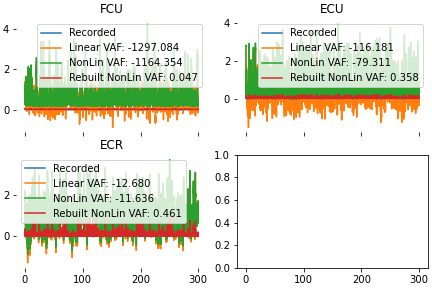

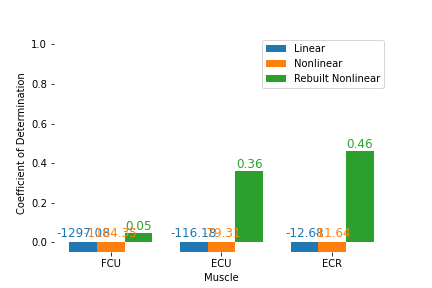

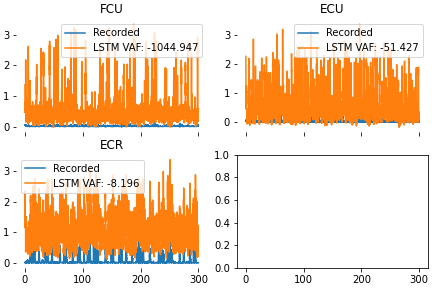

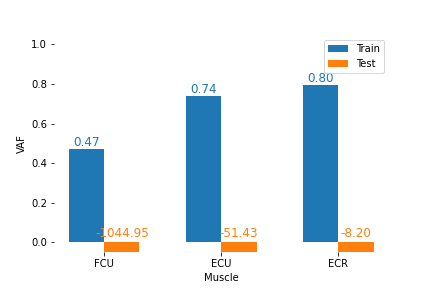

In [15]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['WmTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

Train Iso, test Iso

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
basic_decoder_comparison(train_firing, train_EMG, train_firing, train_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

Train Iso, test WM

In [ ]:
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['IsoTrain'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

In [ ]:
# Hybrid 3 -- this should be a blend of all three, I think for training
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['Hybrid3'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

In [ ]:
# Hybrid 3 -- this should be a blend of all three, I think for training
train_timestamps, train_firing, train_EMG, train_force, train_kin = load_josh_mat(data['Hybrid3'])
_, retrain_firing, retrain_EMG, _, _, = load_josh_mat(data['IsoTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])
basic_decoder_comparison(train_firing, train_EMG, retrain_firing, retrain_EMG, test_firing, test_EMG, test_timestamps, nonlinear_type)
LSTM_comparisons(train_firing, train_EMG, test_firing, test_EMG, test_timestamps)

### Hybrid LSTMs with weighted loss functions

This works a little different from Josh's -- I'm not basing it off of times; instead, I'm manually compiling the train sets I want to use

2022-08-17 14:27:22.781617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:27:22.782100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 14:27:22.782533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 14:27:22.782585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-17 14:27:22.782637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

Epoch 1/20
750/750 - 8s - loss: 435.8358 - mean_absolute_error: 7983.2559 - 8s/epoch - 11ms/step
Epoch 2/20
750/750 - 7s - loss: 1.0796 - mean_absolute_error: 7983.2485 - 7s/epoch - 9ms/step
Epoch 3/20
750/750 - 7s - loss: 0.8590 - mean_absolute_error: 7983.2378 - 7s/epoch - 9ms/step
Epoch 4/20
750/750 - 7s - loss: 0.7834 - mean_absolute_error: 7983.2319 - 7s/epoch - 9ms/step
Epoch 5/20
750/750 - 7s - loss: 0.7368 - mean_absolute_error: 7983.2305 - 7s/epoch - 9ms/step
Epoch 6/20
750/750 - 7s - loss: 0.7109 - mean_absolute_error: 7983.2261 - 7s/epoch - 9ms/step
Epoch 7/20
750/750 - 7s - loss: 0.6885 - mean_absolute_error: 7983.2231 - 7s/epoch - 9ms/step
Epoch 8/20
750/750 - 7s - loss: 0.6652 - mean_absolute_error: 7983.2173 - 7s/epoch - 9ms/step
Epoch 9/20
750/750 - 7s - loss: 0.6569 - mean_absolute_error: 7983.2148 - 7s/epoch - 9ms/step
Epoch 10/20
750/750 - 7s - loss: 0.6592 - mean_absolute_error: 7983.2129 - 7s/epoch - 9ms/step
Epoch 11/20
750/750 - 7s - loss: 0.6359 - mean_absolute_

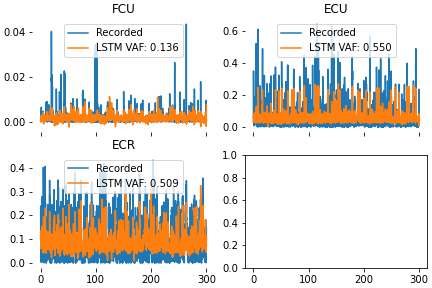

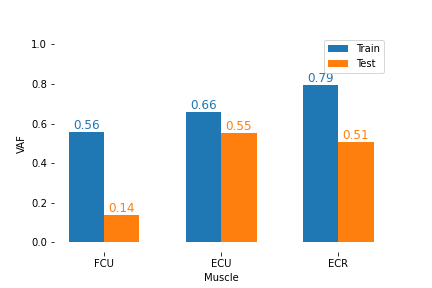

In [8]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['WmTest'])


LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

Epoch 1/20
750/750 - 8s - loss: 536.1801 - mean_absolute_error: 7983.2886 - 8s/epoch - 11ms/step
Epoch 2/20
750/750 - 7s - loss: 0.9632 - mean_absolute_error: 7983.2666 - 7s/epoch - 9ms/step
Epoch 3/20
750/750 - 7s - loss: 0.8160 - mean_absolute_error: 7983.2622 - 7s/epoch - 9ms/step
Epoch 4/20
750/750 - 7s - loss: 0.7655 - mean_absolute_error: 7983.2632 - 7s/epoch - 9ms/step
Epoch 5/20
750/750 - 7s - loss: 0.7236 - mean_absolute_error: 7983.2451 - 7s/epoch - 9ms/step
Epoch 6/20
750/750 - 7s - loss: 0.7021 - mean_absolute_error: 7983.2402 - 7s/epoch - 9ms/step
Epoch 7/20
750/750 - 7s - loss: 0.6752 - mean_absolute_error: 7983.2388 - 7s/epoch - 9ms/step
Epoch 8/20
750/750 - 7s - loss: 0.6797 - mean_absolute_error: 7983.2319 - 7s/epoch - 9ms/step
Epoch 9/20
750/750 - 7s - loss: 0.6568 - mean_absolute_error: 7983.2285 - 7s/epoch - 9ms/step
Epoch 10/20
750/750 - 7s - loss: 0.6412 - mean_absolute_error: 7983.2261 - 7s/epoch - 9ms/step
Epoch 11/20
750/750 - 7s - loss: 0.6320 - mean_absolute_

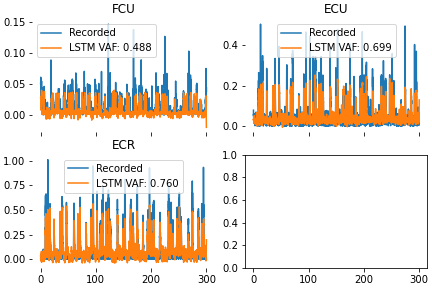

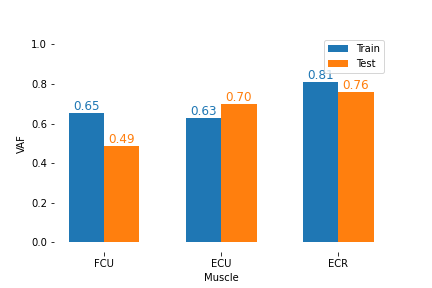

In [9]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])


LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

In [ ]:
_, train_firing_0, train_EMG_0, _, _ = load_josh_mat(data['IsoTrain'])
_, train_firing_1, train_EMG_1, _, _ = load_josh_mat(data['WmTrain'])
test_timestamps, test_firing, test_EMG, test_force, test_kin = load_josh_mat(data['IsoTest'])


LSTM_across_weighted([train_firing_0, train_firing_1], [train_EMG_0, train_EMG_1], test_firing, test_EMG, test_timestamps)

## LSTM

Time to look at some non-linearities!

In [ ]:
# hyper params
layer_0_units = 200
drop_in = 0     # input dropout percentage for LSTM layer
drop_rec = 0    # recurrent dropout for LSTM
drop_lay = 0    # dropout layer?

# # input hyper params -- reshape input vector
# batch_size = 64 # why not? will test to see training accuracy after
# seq_len = train_firing.shape[0]//batch_size # splitting out the batches
n_neurons = train_firing.shape[1] # number of neurons
n_EMGs = train_EMG.shape[1]
seq_len = 10
rnn_train_i = np.zeros((train_firing.shape[0],seq_len, train_firing.shape[1]))
rnn_test_i = np.zeros((test_firing.shape[0],seq_len, test_firing.shape[1]))
rnn_train_o = train_EMG.values
for ii in np.arange(10):
    rnn_train_i[:,ii,:] = train_firing.shift(-ii, fill_value=0).values
    rnn_test_i[:,ii,:] = test_firing.shift(-ii, fill_value=0).values
    


In [ ]:
rnn_train_i.shape

In [ ]:
# Set up the LSTMs
mdl = tf.keras.models.Sequential()


mdl.add(tf.keras.layers.LSTM(layer_0_units, input_shape = (seq_len,n_neurons), dropout=drop_in, recurrent_dropout=drop_rec))
if drop_lay:
    mdl.add(layer_drop = tf.keras.layers.Dropout(drop_lay)) # dropout layer if wanted
mdl.add(tf.keras.layers.Dense(train_EMG.shape[1])) # dense combination layer
mdl.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])


In [ ]:
mdl.fit(rnn_train_i, rnn_train_o, epochs=20, verbose=True)

## Scratch Space
Sometimes the variable viewer isn't very goood

Getting bits of code to work

In [ ]:
# create the lagged input for the wiener filter
wiener_input = pd.DataFrame() # empty dataframe
n_lags = 10 # number of lags
for ii in np.arange(n_lags): # create the lagged dataframe
    col_dict = dict(zip(train_firing.columns, train_firing.columns+f"_lag{ii}"))
    wiener_input = wiener_input.join(train_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')

wiener_test = pd.DataFrame() # empty dataframe
n_lags = 10 # number of lags
for ii in np.arange(n_lags): # create the lagged dataframe
    col_dict = dict(zip(test_firing.columns, test_firing.columns+f"_lag{ii}"))
    wiener_test = wiener_test.join(test_firing.shift(-ii, fill_value=0).rename(columns=col_dict), how='outer')


In [ ]:

# n_poly = 4 # degree of the polynomial

nonlinear_type = 'poly'
# nonlinear_type = 'exponential'
# nonlinear_type = 'sigmoid'


if nonlinear_type == 'poly':
    init_pred = [.1, .1, .1]
elif nonlinear_type == 'exponential':
    init_pred = [1, .1, .2]
elif nonlinear_type == 'sigmoid':
    init_pred = [.1, .5]

mdl_A = linear_model.LinearRegression(fit_intercept=True)
mdl_B = {} # a dictionary of numpy polynomials. Probably a better way to do this, maybe Xuan's method... oh well

mdl_A.fit(wiener_input, train_EMG)# fit the first model
prefit_EMG = mdl_A.predict(wiener_input) # get the initially predicted EMGs
prefit_VAF = metrics.r2_score(train_EMG, prefit_EMG, multioutput='raw_values')
nonlin_EMG = np.zeros(prefit_EMG.shape)

for ii in np.arange(len(train_EMG.columns)):
    muscle = train_EMG.columns[ii]
    mdl_B[muscle] = least_squares(non_linearity_residuals, init_pred, args=(prefit_EMG[:,ii], train_EMG.iloc[:,ii].to_numpy(), nonlinear_type))
    print('--------------------------------------------------------')
    print(muscle)
    print(f"Linear VAF: {prefit_VAF[ii]}")
    nonlin_EMG[:,ii] = non_linearity(mdl_B[muscle].x,(prefit_EMG[:,ii]), nonlinear_type)
    print(f"NonLinear VAF: {metrics.r2_score(train_EMG.iloc[:,ii],nonlin_EMG[:,ii])}")




In [ ]:
# predicting the test set
prefit_test = mdl_A.predict(wiener_test)
prefit_test_VAF = metrics.r2_score(test_EMG, prefit_test, multioutput='raw_values')
nonlin_test = np.zeros(prefit_test.shape)

for ii in np.arange(len(train_EMG.columns)):
    muscle = test_EMG.columns[ii]
    print('--------------------------------------------------------')
    print(muscle)
    print(f"Linear VAF: {prefit_test_VAF[ii]}")
    nonlin_test[:,ii] = non_linearity(mdl_B[muscle].x,(prefit_test[:,ii]), nonlinear_type)
    print(f"NonLinear VAF: {metrics.r2_score(test_EMG.iloc[:,ii],nonlin_test[:,ii])}")

In [ ]:
fig_lin, ax_lin = plt.subplots(nrows=2, ncols=2, sharex=True, constrained_layout=True)


ax_lin[0,0].plot(train_timestamps,emg_preds_train[:,0], label='Predicted')
ax_lin[0,0].plot(train_timestamps, train_EMG.iloc[:,0], label='Recorded')
ax_lin[0,0].set_title(f"{train_EMG.columns[0]}   vaf: {metrics.r2_score(train_EMG.iloc[:,0], emg_preds_train[:,0])}")
_ = ax_lin[0,0].legend()

ax_lin[1,0].plot(train_timestamps,emg_preds_train[:,1], label='Predicted')
ax_lin[1,0].plot(train_timestamps, train_EMG.iloc[:,1], label='Recorded')
ax_lin[1,0].set_title(f"{train_EMG.columns[1]}   vaf: {metrics.r2_score(train_EMG.iloc[:,1], emg_preds_train[:,1])}")
_ = ax_lin[1,0].legend()

ax_lin[0,1].plot(train_timestamps,emg_preds_train[:,2], label='Predicted')
ax_lin[0,1].plot(train_timestamps, train_EMG.iloc[:,2], label='Recorded')
ax_lin[0,1].set_title(f"{train_EMG.columns[2]}   vaf: {metrics.r2_score(train_EMG.iloc[:,2], emg_preds_train[:,2])}")
_ = ax_lin[0,1].legend()

In [ ]:
# plot test data
fig_lin_test, ax_lin_test = plt.subplots(nrows=2, ncols=2, sharex=True, constrained_layout=True)

ax_lin_test[0,0].plot(test_timestamps,emg_preds_test[:,0], label='Predicted')
ax_lin_test[0,0].plot(test_timestamps, test_EMG.iloc[:,0], label='Recorded')
ax_lin_test[0,0].set_title(f"{test_EMG.columns[0]}   vaf: {metrics.r2_score(test_EMG.iloc[:,0], emg_preds_test[:,0])}")
_ = ax_lin_test[0,0].legend()

ax_lin_test[1,0].plot(test_timestamps,emg_preds_test[:,1], label='Predicted')
ax_lin_test[1,0].plot(test_timestamps, test_EMG.iloc[:,1], label='Recorded')
ax_lin_test[1,0].set_title(f"{test_EMG.columns[1]}   vaf: {metrics.r2_score(test_EMG.iloc[:,1], emg_preds_test[:,1])}")
_ = ax_lin_test[1,0].legend()

ax_lin_test[0,1].plot(test_timestamps,emg_preds_test[:,2], label='Predicted')
ax_lin_test[0,1].plot(test_timestamps, test_EMG.iloc[:,2], label='Recorded')
ax_lin_test[0,1].set_title(f"{test_EMG.columns[2]}   vaf: {metrics.r2_score(test_EMG.iloc[:,2], emg_preds_test[:,2])}")
_ = ax_lin_test[0,1].legend()

# ax_lin_test[1,1].plot(test_timestamps,emg_preds_test[:,3], label='Predicted')
# ax_lin_test[1,1].plot(test_timestamps, test_EMG.iloc[:,3], label='Recorded')
# ax_lin_test[1,1].set_title(f"{test_EMG.columns[3]}   vaf: {metrics.r2_score(test_EMG.iloc[:,3], emg_preds_test[:,3])}")
# _ = ax_lin_test[1,1].legend()


In [ ]:

fig_nl, ax_nl = plt.subplots(nrows=2, ncols=2, sharex=True, constrained_layout=True)


ax_nl[0,0].plot(train_timestamps, train_EMG.iloc[:,0], label='Recorded')
ax_nl[0,0].plot(train_timestamps,emg_preds_train[:,0], label='Initial Predicted')
ax_nl[0,0].plot(train_timestamps,nonlin_EMG[:,0], label='NonLin Predicted')
ax_nl[0,0].set_title(f"{train_EMG.columns[0]}   vaf: {metrics.r2_score(train_EMG.iloc[:,0], nonlin_EMG[:,0])}")
_ = ax_nl[0,0].legend()

ax_nl[1,0].plot(train_timestamps, train_EMG.iloc[:,1], label='Recorded')
ax_nl[1,0].plot(train_timestamps,emg_preds_train[:,1], label='Initial Predicted')
ax_nl[1,0].plot(train_timestamps,nonlin_EMG[:,1], label='NonLin Predicted')
ax_nl[1,0].set_title(f"{train_EMG.columns[1]}   vaf: {metrics.r2_score(train_EMG.iloc[:,1], nonlin_EMG[:,1])}")
_ = ax_nl[1,0].legend()

ax_nl[0,1].plot(train_timestamps, train_EMG.iloc[:,2], label='Recorded')
ax_nl[0,1].plot(train_timestamps,emg_preds_train[:,2], label='Initial Predicted')
ax_nl[0,1].plot(train_timestamps,nonlin_EMG[:,2], label='NonLin Predicted')
ax_nl[0,1].set_title(f"{train_EMG.columns[2]}   vaf: {metrics.r2_score(train_EMG.iloc[:,2], nonlin_EMG[:,2])}")
_ = ax_nl[0,1].legend()

# turn off the spines
for axis in ax_nl.flat:
    for spine in ['right','top','bottom','left']:
        axis.spines[spine].set_visible(False)

In [ ]:

# Plotting the test data -- so that we can see how  the non-linearities act between types
fig_nl_test, ax_nl_test = plt.subplots(nrows=2, ncols=2, sharex=True, constrained_layout=True)

muscle_ii = 0
for axis in ax_nl_test.flatten():
    axis.plot(test_timestamps, test_EMG.iloc[:,ii], label='Recorded')
    axis.plot(test_timestamps,prefit_test[:,ii], label=f'Linear VAF: {prefit_test_VAF[ii]}')
    axis.plot(test_timestamps,nonlin_test[:,ii], label=f'NonLin VAF: {nonlin_VAF[ii]}')
    axis.plot(test_timestamps,nonlin_within_test[:,ii], label=f'Rebuilt NonLin VAF: {nonlin_within_VAF[ii]}')
    axis.set_title(f"{test_EMG.columns[ii]}")
    _ = axis.legend()

    # turn off the spines
    for spine in ['right','top','bottom','left']:
        axis.spines[spine].set_visible(False)
    
    muscle_ii += 1
    if muscle_ii == len(test_EMG.columns):
        break # if we've plotted all of the muscles we hav
# ax_nl_test[0,0].plot(test_timestamps, test_EMG.iloc[:,0], label='Recorded')
# ax_nl_test[0,0].plot(test_timestamps,prefit_test[:,0], label='Linear Predicted')
# ax_nl_test[0,0].plot(test_timestamps,nonlin_test[:,0], label='NonLin Predicted')
# ax_nl_test[0,0].set_title(f"{test_EMG.columns[0]}   vaf: {metrics.r2_score(test_EMG.iloc[:,0], nonlin_test[:,0])}")
# _ = ax_nl_test[0,0].legend()

# ax_nl_test[1,0].plot(test_timestamps, test_EMG.iloc[:,1], label='Recorded')
# ax_nl_test[1,0].plot(test_timestamps,prefit_test[:,1], label='Linear Predicted')
# ax_nl_test[1,0].plot(test_timestamps,nonlin_test[:,1], label='NonLin Predicted')
# ax_nl_test[1,0].set_title(f"{test_EMG.columns[1]}   vaf: {metrics.r2_score(test_EMG.iloc[:,1], nonlin_test[:,1])}")
# _ = ax_nl_test[1,0].legend()

# ax_nl_test[0,1].plot(test_timestamps, test_EMG.iloc[:,2], label='Recorded')
# ax_nl_test[0,1].plot(test_timestamps,prefit_test[:,2], label='Linear Predicted')
# ax_nl_test[0,1].plot(test_timestamps,nonlin_test[:,2], label='NonLin Predicted')
# ax_nl_test[0,1].set_title(f"{test_EMG.columns[2]}   vaf: {metrics.r2_score(test_EMG.iloc[:,2], nonlin_test[:,2])}")
# _ = ax_nl_test[0,1].legend()


# # turn off the spines
# for axis in ax_nl_test.flat:
#     for spine in ['right','top','bottom','left']:
#         axis.spines[spine].set_visible(False)

In [ ]:
data['WmBinned'][0][0][2]

In [ ]:
train_firing.shape[0]//64

In [ ]:
train_firing.shape

In [ ]:
train_firing.iloc[:time_len*batch_size,:].values.reshape()

In [ ]:
rnn_train.shape

In [ ]:
pred_train = mdl.predict(rnn_train_i)

In [ ]:
pred_test = mdl.predict(rnn_test_i)

In [ ]:
fig,ax = plt.subplots(nrows=3, sharex=True)

for ii in np.arange(3):
    ax[ii].plot(pred_train[:,ii])
    ax[ii].plot(train_EMG.values[:,ii])


In [ ]:
fig,ax = plt.subplots(nrows=3, sharex=True)

for ii in np.arange(3):
    ax[ii].plot(pred_test[:,ii])
    ax[ii].plot(test_EMG.values[:,ii])


In [ ]:
train_EMG.to_numpy()

In [ ]:
train_EMG_list = [train_EMG_1.to_numpy()]

loss_weights = np.ndarray((0,3)) # empty numpy array

for target in train_EMG_list:
    aa = np.std(target, axis=0)
#     temp_SD = np.matmul(np.ones((target.shape[0],1)),np.std(target, axis=0).reshape(1,-1))
#     loss_weights = np.append(loss_weights,temp_SD, axis=0)


In [ ]:
1./aa

In [ ]:
np.maximum(train_firing_1)